# Imports

In [0]:
import pandas as pd 
import numpy as np
import requests
import io
import re
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import os
import json
import random

In [2]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
logpath = 'drive/My Drive/mmath_cs/CHI_2020/typealike-study/data/'
logfns = os.listdir(logpath)

# these are columns that define a single trial
columns = ['Participant',            # participant id (P01, P02, ...)
           'Block',                  # upto 3
           'Sequence',               # upto 360
           'Trial',                  # upto 720
           'Target_Type',              # what condition this particpant did (typing, pointing, gesture)
           'Target_Name',                  # whats the specific label of this target
           'Start_Time',
           'End_Time',
           'First_Reaction_Time',
#            'Mode_In_Time',  #time in ms
            ]

# time format in the example log is like 2018/07/10-16:41:54.4902
# see https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior
# time_format = '%Y/%m/%d-%H:%M:%S.%f'
time_format = '%Y-%m-%d %H:%M:%S.%f'

In [0]:
# helper functions

# https://stackoverflow.com/questions/17060039/split-string-at-nth-occurrence-of-a-given-character
def splitn(string, spliton, n):
    """split 'string' on nth occurence of 'spliton'
    """
    groups = string.split(spliton)
    return spliton.join(groups[:n]), spliton.join(groups[n:])


def ms_delta(t):
    """convert timedelta t to milliseconds
    """
    return round(t.seconds * 1000 + t.microseconds / 1000)

# Test

## Make dictionary

In [0]:
# data = open(logpath+'../mode_switching.csv', 'w')
# data.write(','.join(columns) + '\n')

#     print(logfn)
logfn = "pilot_nalin_experiment_2019-09-10-18-03-00.txt"
# logfn = "test_nalin_experiment_2019-09-11-03-00-23.txt"
# filename = logfn.replace(".txt",".txt")
# data = open(logpath+'../csv/'+filename, 'w')
# data.write(','.join(columns) + '\n')

modeSwitch=False
currentTaskFirstAttempt=0;
previousTaskEndTime=0;
nextTaskStart=False;
prev_task=""
current_block = 0
current_sequence = 0

log = open(logpath + logfn, 'r')

#     initalize a dictionary of values we'll write to the datafile
dict_postures = {
#     "0":{
#       "0":[], "1":[],"2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[],
#       "10":[], "11":[],"12":[], "13":[], "14":[], "15":[], "16":[], "17":[], "18":[], "19":[],
#       "20":[], "21":[],"22":[], "23":[], "24":[], "25":[], "26":[], "27":[], "28":[], "29":[],
#       "30":[], "31":[],"32":[], "33":[], "34":[], "35":[]
#     },
#     "1":{
#       "0":[], "1":[],"2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[],
#       "10":[], "11":[],"12":[], "13":[], "14":[], "15":[], "16":[], "17":[], "18":[], "19":[],
#       "20":[], "21":[],"22":[], "23":[], "24":[], "25":[], "26":[], "27":[], "28":[], "29":[],
#       "30":[], "31":[],"32":[], "33":[], "34":[], "35":[]
#     },
#     "2":{
#       "0":[], "1":[],"2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[],
#       "10":[], "11":[],"12":[], "13":[], "14":[], "15":[], "16":[], "17":[], "18":[], "19":[],
#       "20":[], "21":[],"22":[], "23":[], "24":[], "25":[], "26":[], "27":[], "28":[], "29":[],
#       "30":[], "31":[],"32":[], "33":[], "34":[], "35":[]
#     },
#     "3":{
#       "0":[], "1":[],"2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[],
#       "10":[], "11":[],"12":[], "13":[], "14":[], "15":[], "16":[], "17":[], "18":[], "19":[],
#       "20":[], "21":[],"22":[], "23":[], "24":[], "25":[], "26":[], "27":[], "28":[], "29":[],
#       "30":[], "31":[],"32":[], "33":[], "34":[], "35":[]
#     },
#     "4":{
#       "0":[], "1":[],"2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[],
#       "10":[], "11":[],"12":[], "13":[], "14":[], "15":[], "16":[], "17":[], "18":[], "19":[],
#       "20":[], "21":[],"22":[], "23":[], "24":[], "25":[], "26":[], "27":[], "28":[], "29":[],
#       "30":[], "31":[],"32":[], "33":[], "34":[], "35":[]
#     },
#     "5":{
#       "0":[], "1":[],"2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[],
#       "10":[], "11":[],"12":[], "13":[], "14":[], "15":[], "16":[], "17":[], "18":[], "19":[],
#       "20":[], "21":[],"22":[], "23":[], "24":[], "25":[], "26":[], "27":[], "28":[], "29":[],
#       "30":[], "31":[],"32":[], "33":[], "34":[], "35":[]
#     },
#     "6":{
#       "0":[], "1":[],"2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[],
#       "10":[], "11":[],"12":[], "13":[], "14":[], "15":[], "16":[], "17":[], "18":[], "19":[],
#       "20":[], "21":[],"22":[], "23":[], "24":[], "25":[], "26":[], "27":[], "28":[], "29":[],
#       "30":[], "31":[],"32":[], "33":[], "34":[], "35":[]
#     },
#     "7":{
#       "0":[], "1":[],"2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[],
#       "10":[], "11":[],"12":[], "13":[], "14":[], "15":[], "16":[], "17":[], "18":[], "19":[],
#       "20":[], "21":[],"22":[], "23":[], "24":[], "25":[], "26":[], "27":[], "28":[], "29":[],
#       "30":[], "31":[],"32":[], "33":[], "34":[], "35":[]
#     },
#     "8":{
#       "0":[], "1":[],"2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[],
#       "10":[], "11":[],"12":[], "13":[], "14":[], "15":[], "16":[], "17":[], "18":[], "19":[],
#       "20":[], "21":[],"22":[], "23":[], "24":[], "25":[], "26":[], "27":[], "28":[], "29":[],
#       "30":[], "31":[],"32":[], "33":[], "34":[], "35":[]
#     },
#     "9":{
#       "0":[], "1":[],"2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[],
#       "10":[], "11":[],"12":[], "13":[], "14":[], "15":[], "16":[], "17":[], "18":[], "19":[],
#       "20":[], "21":[],"22":[], "23":[], "24":[], "25":[], "26":[], "27":[], "28":[], "29":[],
#       "30":[], "31":[],"32":[], "33":[], "34":[], "35":[]
#     }
}


# we'll go through line-by-line
line_num = 0
trial_started = False
for row in log:
    if row[0] == '#':             
        continue
    line_num += 1
    # split the line
    row_list = row.strip().split(',')
#         if row_list[1] == :
#           pass
#         if row_list[2]
    if trial_started:# and not first_reaction_recorded:
      if row_list[1] == 'I':
#         print(row)
        row = row.replace(row.split(",", 1)[0],"XXXX")
#         dict_postures[current_block][current_sequence].append(row)
        dict_postures[current_block+current_sequence].append(row)
        
    if row_list[2] == "trial":
      row_split_list = splitn(row, ',', 3)
#         experiment_block = (row_list[1], row_list[2])
      row_inner_dict = {}
      try:
          # parse the json event data
#                 print("PARSIG JSON")
#                 print(r[1])
#               print(row_split_list)
          row_inner_dict = json.loads(row_split_list[1])
      except Exception as e:
          print('error parsing json event data on row{}: {}\n{}'.format(line_num, row_list[3], e))

      if row_inner_dict["type"] == "start" and row_inner_dict["targetType"] == "posture":
        trial_started = True
        current_block = row_inner_dict["blockNum"]
        current_sequence = row_inner_dict["sequenceNum"]
        dict_postures[current_block+current_sequence] = []
      elif row_inner_dict["type"] == "end" and row_inner_dict["targetType"] == "posture":
        trial_started = False
#         print("\n\n")



In [28]:
dict_postures["026"]

['XXXX,I,posture,typing\n',
 'XXXX,I,posture,typing\n',
 'XXXX,I,keyboard,keyreleased,10,none\n',
 'XXXX,I,posture,typing\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,Left_Open_90_Below\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,Left_Open_90_Below\n',
 'XXXX,I,posture,Left_Open_90_Below\n',
 'XXXX,I,posture,Left_Open_90_Below\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,Right_Open_90_Below\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,no_posture\n',
 'XXXX,I,posture,Right_Open_90_Be

## Edit

In [35]:
# data = open(logpath+'../mode_switching.csv', 'w')
# data.write(','.join(columns) + '\n')

for logfn in logfns:

#     print(logfn)
    filename = logfn.replace(".txt",".txt")
    data = open(logpath+'../files/'+filename, 'w')
#     data.write(','.join(columns) + '\n')
    
    modeSwitch=False
    currentTaskFirstAttempt=0;
    previousTaskEndTime=0;
    nextTaskStart=False;
    prev_task=""
    
    log = open(logpath + logfn, 'r')
    
#     initalize a dictionary of values we'll write to the datafile
    
    # initalize temporary values
    trial_start_time = 0

    # we'll go through line-by-line
    line_num = 0
    temp_logs = ""
    previous_buffer = ""
    flag = True
    trial_started = False
    for row in log:
#         print(row)
        
        if row[0] == '#':
          data.write(row)
          continue
        line_num += 1
        # split the line
        row_list = row.strip().split(',')
#         if row_list[1] == :
#           pass
#         if row_list[2]
        if trial_started:# and not first_reaction_recorded:
#           print(row)
          if row_list[1] == 'I':
            flag = False
            if row_list[2] == 'posture':
              previous_buffer += row
              c_b = str(random.choice([0,8]))
              posture_list = dict_postures["0"+current_sequence]
              time_diff = int(row_list[0]) - int(trial_start_time)
              c = 0
#               bucket = 1 if time_diff < len(posture_list) else int(time_diff/len(posture_list))
#               print(time_diff," ", filename, " # ", )
              while(c < time_diff):
#                 print(c," # ", time_diff, " # ", len(posture_list), " # ", trial_start_time)
                if c/len(posture_list) >= len(posture_list):
                  break
  #               posture_list[c/30]    
                temp_logs += posture_list[int(c/len(posture_list))].replace("XXXX",str(int(trial_start_time)+c))
                c+=len(posture_list) #30 fps
  #             for i in posture_list:
  #             temp_logs += row_padding.replace("XXXX",ts)
  #             print(temp_logs)
    
        if row_list[2] == "trial":
#             print(row)
          row_split_list = splitn(row, ',', 3)
    #         experiment_block = (row_list[1], row_list[2])
          row_inner_dict = {}
          try:
              # parse the json event data
    #                 print("PARSING JSON")
    #                 print(r[1])
    #               print(row_split_list)
              row_inner_dict = json.loads(row_split_list[1])
          except Exception as e:
              print('error parsing json event data on row{}: {}\n{}'.format(line_num, row_list[3], e))

          if row_inner_dict["type"] == "start" and row_inner_dict["targetType"] == "posture":
            trial_started = True
            current_block = row_inner_dict["blockNum"]
#             current_block = str(int(int(row_inner_dict["blockNum"])/2))
            current_sequence = row_inner_dict["sequenceNum"]
            trial_start_time = row_list[0]
#             dict_postures[current_block+current_sequence] = []
          elif row_inner_dict["type"] == "end" and row_inner_dict["targetType"] == "posture":
            trial_started = False
            # save to log
            #               datarow = [d[k] for k in columns]
#             print(temp_logs)
            row = temp_logs + previous_buffer + row
            temp_logs = ""
            previous_buffer = ""
            flag = True
#             print(filename," # ",current_block," # ",current_sequence)
            
#             print("------\n")
            #               datarow_csv = ','.join(str(i) for i in datarow)
            #                     print(datarow_csv)
        if flag:
          data.write(row)
        

#           if row_inner_dict["type"] == "start":
#             trial_started = True
#             first_reaction_recorded = False
#             d['Start_Time'] = row_list[0]
# #             d['Participant'] = row_inner_dict['participantid']
#             d['Target_Type'] = row_inner_dict["targetType"]
#             d['Target_Name'] = row_inner_dict["label"]
#             d['Block'] = row_inner_dict["blockNum"]
#             d['Sequence'] = row_inner_dict["sequenceNum"]
#             d['Trial'] = trial
#             trial+=1
#           elif row_inner_dict["type"] == "end":
#             trial_started = False
            
#             # save to log
# #               datarow = [d[k] for k in columns]
#             row = temp_logs + row
# #               datarow_csv = ','.join(str(i) for i in datarow)
#   #                     print(datarow_csv)
#             data.write(row + '\n')
#             temp_logs = ""
    print(filename)
    data.close()
#     break

participant_31_experiment_2019-08-29-18-49-40.txt
participant_39_experiment_2019-09-04-16-12-13.txt
participant_41_experiment_2019-09-04-19-05-57.txt
participant_35_experiment_2019-09-03-15-57-34.txt
participant_36_experiment_2019-09-03-16-58-26.txt
participant_37_experiment_2019-09-03-23-06-46.txt
participant_33_experiment_2019-09-02-15-48-35.txt
participant_38_experiment_2019-09-04-14-54-31.txt
participant_40_experiment_2019-09-04-18-12-17.txt
participant_34_experiment_2019-09-02-17-51-29.txt
participant_42_experiment_2019-09-05-14-19-57.txt
participant_49_experiment_2019-09-06-20-00-11.txt
participant_45_experiment_2019-09-05-18-50-20.txt
participant_47_experiment_2019-09-06-16-47-27.txt
participant_43_experiment_2019-09-05-16-01-45.txt
participant_46_experiment_2019-09-05-22-37-21.txt
participant_44_experiment_2019-09-05-17-25-07.txt
participant_48_experiment_2019-09-06-18-51-31.txt
participant_32_experiment_2019-08-30-16-52-53.txt
participant_50_experiment_2019-09-10-14-21-34.txt


# New Section

In [0]:
logpath = 'drive/My Drive/mmath_cs/CHI_2020/typealike-study/files/'
logfns = os.listdir(logpath)

# these are columns that define a single trial
columns = ['Participant',            # participant id (P01, P02, ...)
           'Block',                  # upto 3
           'Sequence',               # upto 360
           'Trial',                  # upto 720
           'Target_Type',              # what condition this particpant did (typing, pointing, gesture)
           'Target_Name',                  # whats the specific label of this target
           'Start_Time',
           'End_Time',
           'First_Reaction_Time',
           'Reference_Posture_Count',
           'Incorrect_Posture_Count',
           'Error'
#            'Mode_In_Time',  #time in ms
            ]

# time format in the example log is like 2018/07/10-16:41:54.4902
# see https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior
# time_format = '%Y/%m/%d-%H:%M:%S.%f'
time_format = '%Y-%m-%d %H:%M:%S.%f'

In [37]:
logpath

'drive/My Drive/mmath_cs/CHI_2020/typealike-study/files/'

In [38]:
# data = open(logpath+'../mode_switching.csv', 'w')
# data.write(','.join(columns) + '\n')

for logfn in logfns:

#     print(logfn)
    filename = logfn.replace(".txt",".csv")
    data = open(logpath+'../csv/'+filename, 'w')
    data.write(','.join(columns) + '\n')
    
    modeSwitch=False
    currentTaskFirstAttempt=0;
    previousTaskEndTime=0;
    nextTaskStart=False;
    prev_task=""
    
    log = open(logpath + logfn, 'r')
    
#     initalize a dictionary of values we'll write to the datafile
    d = {e:0 for e in columns}
    
    # initalize temporary values
    trial_start_time = 0

    # we'll go through line-by-line
    line_num = 0
    trial = 0
    trial_started = False
    first_reaction_recorded = False
    reference_posture_count = 0
    incorrect_posture_count = 0
    for row in log:
#         print(row)
        if row[0] == '#':             
            continue
        line_num += 1
        # split the line
        row_list = row.strip().split(',')
#         if row_list[1] == :
#           pass
#         if row_list[2]
        if trial_started:
          
          if row_list[1] == 'I':
            if row_list[2] == "posture" and d['Target_Name'] != row_list[3]:
              if row_list[3] not in ["typing", "no_posture"]:
                incorrect_posture_count +=1
              else:
                reference_posture_count +=1
                
            if not first_reaction_recorded and row_list[2] == 'keyboard':
              first_reaction_time = row_list[0]
              first_reaction_recorded = True
    
        if row_list[1] == 'E':
          row_split_list = splitn(row, ',', 3)
  #         experiment_block = (row_list[1], row_list[2])
          row_inner_dict = {}
          try:
              # parse the json event data
  #                 print("PARSIG JSON")
  #                 print(r[1])
#               print(row_split_list)
              row_inner_dict = json.loads(row_split_list[1])
          except Exception as e:
              print('error parsing json event data on row{}: {}\n{}'.format(line_num, row_list[3], e))

          if row_list[2] == "experiment":
            d['Participant'] = row_inner_dict['participantid']

          if row_list[2] == "trial":
#             print(row)

            if row_inner_dict["type"] == "start":
              trial_started = True
              first_reaction_recorded = False
              d['Start_Time'] = row_list[0]
  #             d['Participant'] = row_inner_dict['participantid']
              d['Target_Type'] = row_inner_dict["targetType"]
              d['Target_Name'] = row_inner_dict["label"]
              d['Block'] = row_inner_dict["blockNum"]
              d['Sequence'] = row_inner_dict["sequenceNum"]
              d['Trial'] = trial
#               if row_inner_dict["type"] == "posture":
#               if row_inner_dict["targetType"] == "posture":
                
  
              trial+=1
            elif row_inner_dict["type"] == "end":
              trial_started = False
              d['End_Time'] = row_list[0]
              d['First_Reaction_Time'] = first_reaction_time if d['Target_Type'] == 'word' else row_list[0] # ["shortcut", "posture", "click"]
#               d['Mode_In_Time'] = int(d['First_Reaction_Time']) - int(d['Start_Time'])
              d['Reference_Posture_Count'] = reference_posture_count
              d['Incorrect_Posture_Count'] = incorrect_posture_count
              d['Error'] = False if row_inner_dict["action"] == "hit" else True
              reference_posture_count = 0
              incorrect_posture_count = 0
  

              # save to log
              datarow = [d[k] for k in columns]
              datarow_csv = ','.join(str(i) for i in datarow)
    #                     print(datarow_csv)
              data.write(datarow_csv + '\n')
            
    data.close()
    print(filename)

participant_31_experiment_2019-08-29-18-49-40.csv
participant_39_experiment_2019-09-04-16-12-13.csv
participant_41_experiment_2019-09-04-19-05-57.csv
participant_35_experiment_2019-09-03-15-57-34.csv
participant_36_experiment_2019-09-03-16-58-26.csv
participant_37_experiment_2019-09-03-23-06-46.csv
participant_33_experiment_2019-09-02-15-48-35.csv
participant_38_experiment_2019-09-04-14-54-31.csv
participant_40_experiment_2019-09-04-18-12-17.csv
participant_34_experiment_2019-09-02-17-51-29.csv
participant_42_experiment_2019-09-05-14-19-57.csv
participant_49_experiment_2019-09-06-20-00-11.csv
participant_45_experiment_2019-09-05-18-50-20.csv
participant_47_experiment_2019-09-06-16-47-27.csv
participant_43_experiment_2019-09-05-16-01-45.csv
participant_46_experiment_2019-09-05-22-37-21.csv
participant_44_experiment_2019-09-05-17-25-07.csv
participant_48_experiment_2019-09-06-18-51-31.csv
participant_32_experiment_2019-08-30-16-52-53.csv
participant_50_experiment_2019-09-10-14-21-34.csv


In [39]:
f = "/content/drive/My Drive/mmath_cs/CHI_2020/typealike-study/csv/participant_50_experiment_2019-09-10-14-21-34.csv"
df = pd.read_csv(f)
df.head()

,Participant,Block,Sequence,Trial,Target_Type,Target_Name,Start_Time,End_Time,First_Reaction_Time,Reference_Posture_Count,Incorrect_Posture_Count,Error
0,participant_50,0,0,0,click,click me,1568139699074,1568139702382,1568139702382,0,0,False
1,participant_50,0,0,1,posture,Left_Close_0_On,1568139702410,1568139704286,1568139704286,33,0,False
2,participant_50,0,1,2,word,snake,1568139704309,1568139708043,1568139706577,0,0,False
3,participant_50,0,1,3,posture,Left_Close_0_Below,1568139708074,1568139709687,1568139709687,31,0,False
4,participant_50,0,2,4,click,click me,1568139709710,1568139712142,1568139712142,0,0,False


In [40]:
csv_Path = "/content/drive/My Drive/mmath_cs/CHI_2020/typealike-study/csv/"
csv_files = os.listdir(csv_Path)

for csv in csv_files:
#   print(csv_Path+csv)
  df = pd.read_csv(csv_Path+csv)
#   print(df["Participant"][0])
  if df["Participant"][0] == "pilot_nalin":
    continue
#   if df["Participant"][0] == "participant_44":
#     dd = df.loc[df["Reference_Posture_Count"] < df["Incorrect_Posture_Count"]]
#     break
  print(df["Participant"][0], df.loc[df["Reference_Posture_Count"] < df["Incorrect_Posture_Count"]]["Incorrect_Posture_Count"].count())


participant_39 5
participant_41 5
participant_35 5
participant_36 5
participant_37 5
participant_33 4
participant_38 5
participant_40 5
participant_34 5
participant_42 5
participant_49 5
participant_45 5
participant_47 2
participant_43 5
participant_46 5
participant_44 6
participant_48 5
participant_31 5
participant_32 5
participant_50 5


In [47]:
f = "/content/drive/My Drive/mmath_cs/CHI_2020/typealike-study/csv/participant_31_experiment_2019-08-29-18-49-40.csv"
df_all = pd.read_csv(f)
csv_Path = "/content/drive/My Drive/mmath_cs/CHI_2020/typealike-study/csv/"
csv_files = os.listdir(csv_Path)

for csv in csv_files:
  df = pd.read_csv(csv_Path+csv)
  if df["Participant"][0] == "participant_31" or df["Participant"][0] == "pilot_nalin":
    continue
#   print()
  df_all = df_all.append(df, ignore_index=True)
#   print(df["Participant"][0])
#   if df["Participant"][0] == "participant_44":
#     dd = df.loc[df["Reference_Posture_Count"] < df["Incorrect_Posture_Count"]]
#     break
#   print(df["Participant"][0], df.loc[df["Reference_Posture_Count"] < df["Incorrect_Posture_Count"]]["Incorrect_Posture_Count"].count())
# df_all.loc[(df_all["Reference_Posture_Count"] < df_all["Incorrect_Posture_Count"]) & (df_all["Target_Name"]=="Right_Close_180_Beside")]
set(df_all.loc[(df_all["Reference_Posture_Count"] < df_all["Incorrect_Posture_Count"])]["Target_Name"])#) & (df_all["Target_Name"]=="Right_Close_0_Below")]
# {'Right_Close_0_Below', 'Right_Close_180_Beside', 'Right_Open_180_Below'}
# df_all.loc[(df_all["Reference_Posture_Count"] < df_all["Incorrect_Posture_Count"])]

{'Right_Close_0_Below', 'Right_Open_180_Below'}

In [43]:
df_all.loc[(df_all["Reference_Posture_Count"] < df_all["Incorrect_Posture_Count"])]

,Participant,Block,Sequence,Trial,Target_Type,Target_Name,Start_Time,End_Time,First_Reaction_Time,Reference_Posture_Count,Incorrect_Posture_Count,Error
69,participant_31,0,34,69,posture,Right_Open_180_Below,1567119128372,1567119129784,1567119129784,9,21,False
213,participant_31,2,34,213,posture,Right_Open_180_Below,1567119489793,1567119491072,1567119491072,9,21,False
357,participant_31,4,34,357,posture,Right_Open_180_Below,1567119764969,1567119766316,1567119766316,9,21,False
501,participant_31,6,34,501,posture,Right_Open_180_Below,1567120078856,1567120080903,1567120080903,9,21,False
645,participant_31,8,34,645,posture,Right_Open_180_Below,1567120381067,1567120382851,1567120382851,9,21,False
789,participant_39,0,34,69,posture,Right_Open_180_Below,1567628050513,1567628051589,1567628051589,9,21,False
933,participant_39,2,34,213,posture,Right_Open_180_Below,1567628420221,1567628421529,1567628421529,9,21,False
1077,participant_39,4,34,357,posture,Right_Open_180_Below,1567628708427,1567628709574,1567628709574,9,21,False
1221,participant_39,6,34,501,posture,Right_Open_180_Below,1567628994374,1567628995582,1567628995582,9,21,False
1365,participant_39,8,34,645,posture,Right_Open_180_Below,1567629283082,1567629284862,1567629284862,9,21,False


In [205]:
# print(df.loc[(df['Target_Type'] == "posture") & (df['Block'] == 0)]["Mode_In_Time"].mean(),df.loc[(df['Target_Type'] == "posture") & (df['Block'] == 0)]["Mode_In_Time"].std() )
# print(df.loc[(df['Target_Type'] == "posture") & (df['Block'] == 2)]["Mode_In_Time"].mean(),df.loc[(df['Target_Type'] == "posture") & (df['Block'] == 2)]["Mode_In_Time"].std() )
# print(df.loc[(df['Target_Type'] == "posture") & (df['Block'] == 4)]["Mode_In_Time"].mean(),df.loc[(df['Target_Type'] == "posture") & (df['Block'] == 4)]["Mode_In_Time"].std() )
# print(df.loc[(df['Target_Type'] == "posture") & (df['Block'] == 6)]["Mode_In_Time"].mean(),df.loc[(df['Target_Type'] == "posture") & (df['Block'] == 6)]["Mode_In_Time"].std() )
# print(df.loc[(df['Target_Type'] == "posture") & (df['Block'] == 8)]["Mode_In_Time"].mean(),df.loc[(df['Target_Type'] == "posture") & (df['Block'] == 8)]["Mode_In_Time"].std() )
df.loc[df["Reference_Posture_Count"] < df["Incorrect_Posture_Count"]].count()

Participant                29
Block                      29
Sequence                   29
Trial                      29
Target_Type                29
Target_Name                29
Start_Time                 29
End_Time                   29
First_Reaction_Time        29
Reference_Posture_Count    29
Incorrect_Posture_Count    29
Error                      29
dtype: int64

In [88]:
df["Block"][0]

0

In [89]:
df.head()

,Participant,Block,Sequence,Trial,Target_Type,Target_Name,Start_Time,End_Time,First_Reaction_Time
0,participant-31,0,0,0,click,click me,1567118993864,1567118995310,1567118995310
1,participant-31,0,0,1,posture,Left_Close_0_On,1567118995331,1567118996645,1567118996645
2,participant-31,0,1,2,word,fully,1567118996665,1567118999400,1567118998403
3,participant-31,0,1,3,posture,Left_Close_0_Below,1567118999434,1567119001175,1567119001175
4,participant-31,0,2,4,click,click me,1567119001198,1567119003199,1567119003199


In [0]:
# print(df.loc[(df['Target_Type'] == "shortcut") & (df['Block'] == 1)]["Mode_In_Time"].mean())
# print(df.loc[(df['Target_Type'] == "shortcut") & (df['Block'] == 3)]["Mode_In_Time"].mean())
# print(df.loc[(df['Target_Type'] == "shortcut") & (df['Block'] == 5)]["Mode_In_Time"].mean())
# print(df.loc[(df['Target_Type'] == "shortcut") & (df['Block'] == 7)]["Mode_In_Time"].mean())
# print(df.loc[(df['Target_Type'] == "shortcut") & (df['Block'] == 9)]["Mode_In_Time"].mean())
mode_in_time_list = pd.Series([]) 
mode_out_time_list = pd.Series([])
exp_block_list = pd.Series([])
for i in range(len(df)): 
  start_time = df["Start_Time"][i]
  end_time = df["End_Time"][i]
  first_reaction_time = df["First_Reaction_Time"][i]
  mode_in_time_list[i] = 0 if i == 0 else mode_out_time_list[i-1]
#   print(i, " ", len(df))
  mode_out_time_list[i] = 0 if (i+1 == len(df) or  df["Block"][i] != df["Block"][i+1]) else (df["First_Reaction_Time"][i+1] - df["First_Reaction_Time"][i])
  exp_block_list[i] = int(df["Block"][i]/2)

df.insert(4, "EBlock", exp_block_list)
df.insert(10, "Mode_In_Time", mode_in_time_list)
df.insert(11, "Mode_Out_Time", mode_out_time_list)
df = df.rename(columns={"Sequence":"Sub_Sequence", "Block":"Sequence", "EBlock": "Block"})

In [0]:
total_time_list = pd.Series([])
for i in range(len(df)): 
  total_time_list[i] = df["Mode_In_Time"][i] + df["Mode_Out_Time"][i]

df.insert(12, "Total_Time", total_time_list)

In [99]:
data = df.loc[(df['Target_Type'] == "shortcut") | (df['Target_Type'] == "posture")]
data.head()

,Participant,Sequence,Sub_Sequence,Trial,Block,Target_Type,Target_Name,Start_Time,End_Time,First_Reaction_Time,Mode_In_Time,Mode_Out_Time,Total_Time
1,participant-31,0,0,1,0,posture,Left_Close_0_On,1567118995331,1567118996645,1567118996645,1335,1758,3093
3,participant-31,0,1,3,0,posture,Left_Close_0_Below,1567118999434,1567119001175,1567119001175,2772,2024,4796
5,participant-31,0,2,5,0,posture,Left_Close_0_Beside,1567119003230,1567119004877,1567119004877,1678,1523,3201
7,participant-31,0,3,7,0,posture,Left_Close_90_On,1567119008531,1567119009846,1567119009846,3446,2419,5865
9,participant-31,0,4,9,0,posture,Left_Close_90_Below,1567119014167,1567119015578,1567119015578,3313,1688,5001


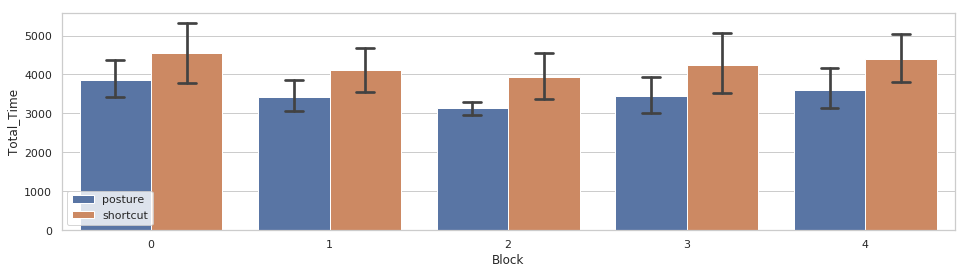

In [100]:
sns.set(style="whitegrid")
plt.figure(figsize=(16,4))
# plt.xticks(rotation=90)
ax = sns.barplot(x="Block", y="Total_Time", hue="Target_Type", data=data, capsize=0.1)
ax.legend(loc='lower left')

In [91]:
data = df.loc[(df['Target_Type'] == "shortcut") | (df['Target_Type'] == "posture")]
data.head()

,Participant,Sequence,Sub_Sequence,Trial,Block,Target_Type,Target_Name,Start_Time,End_Time,First_Reaction_Time,Mode_In_Time,Mode_Out_Time
1,participant-31,0,0,1,0,posture,Left_Close_0_On,1567118995331,1567118996645,1567118996645,1335,1758
3,participant-31,0,1,3,0,posture,Left_Close_0_Below,1567118999434,1567119001175,1567119001175,2772,2024
5,participant-31,0,2,5,0,posture,Left_Close_0_Beside,1567119003230,1567119004877,1567119004877,1678,1523
7,participant-31,0,3,7,0,posture,Left_Close_90_On,1567119008531,1567119009846,1567119009846,3446,2419
9,participant-31,0,4,9,0,posture,Left_Close_90_Below,1567119014167,1567119015578,1567119015578,3313,1688


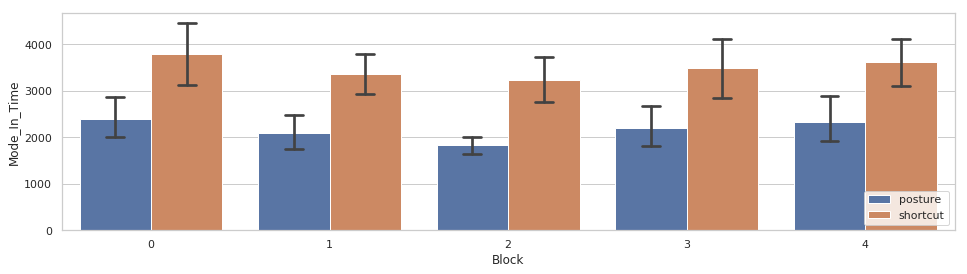

In [92]:
sns.set(style="whitegrid")
plt.figure(figsize=(16,4))
# plt.xticks(rotation=90)
ax = sns.barplot(x="Block", y="Mode_In_Time", hue="Target_Type", data=data, capsize=0.1)
ax.legend(loc='lower right')

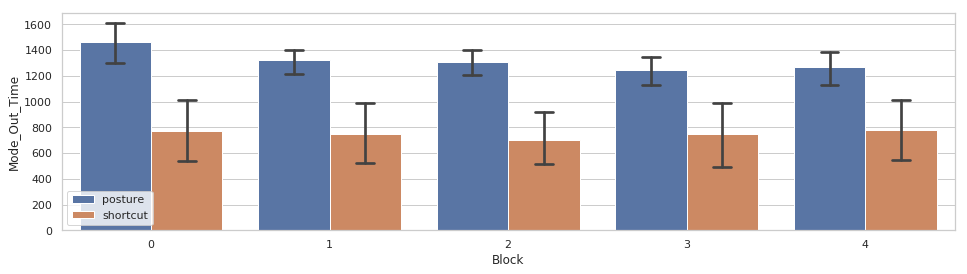

In [93]:
sns.set(style="whitegrid")
plt.figure(figsize=(16,4))
# plt.xticks(rotation=90)
ax = sns.barplot(x="Block", y="Mode_Out_Time", hue="Target_Type", data=data, capsize=0.1)
ax.legend(loc='lower left')

In [83]:
df.loc[(df["Block"]==2) & (df["Target_Type"]=="posture")]

,Participant,Sequence,Sub_Sequence,Trial,Block,Target_Type,Target_Name,Start_Time,End_Time,First_Reaction_Time,Mode_In_Time,Mode_Out_Time
289,participant-31,4,0,289,2,posture,Left_Close_0_On,1567119657902,1567119659080,1567119659080,1215,1222
291,participant-31,4,1,291,2,posture,Left_Close_0_Below,1567119661199,1567119662682,1567119662682,2380,1518
293,participant-31,4,2,293,2,posture,Left_Close_0_Beside,1567119664233,1567119665511,1567119665511,1311,1190
295,participant-31,4,3,295,2,posture,Left_Close_90_On,1567119667633,1567119668715,1567119668715,2014,1022
297,participant-31,4,4,297,2,posture,Left_Close_90_Below,1567119670702,1567119671681,1567119671681,1944,1685
299,participant-31,4,5,299,2,posture,Left_Close_90_Beside,1567119673404,1567119675281,1567119675281,1915,1319
301,participant-31,4,6,301,2,posture,Left_Close_180_On,1567119677569,1567119678782,1567119678782,2182,1221
303,participant-31,4,7,303,2,posture,Left_Close_180_Below,1567119680035,1567119681177,1567119681177,1174,1627
305,participant-31,4,8,305,2,posture,Left_Close_180_Beside,1567119682833,1567119684117,1567119684117,1313,1449
307,participant-31,4,9,307,2,posture,Left_Open_0_On,1567119686837,1567119687910,1567119687910,2344,1495


# Load Data

In [0]:
BASE_URL = "https://docs.google.com/spreadsheets/d/1VpLXByvbTfbgupDNWcUaBxdk72cW9FRExs0AgRVaF1g/export?format=csv&"
URL_PARTICIPANTS = BASE_URL+"gid=611260429"
URL_POSTURES = BASE_URL+"gid=961690077"
content_participants = requests.get(URL_PARTICIPANTS, verify=False).content
content_postures = requests.get(URL_POSTURES, verify=False).content
df_participants = pd.read_csv(io.StringIO(content_participants.decode('utf-8'))) 
df_postures = pd.read_csv(io.StringIO(content_postures.decode('utf-8'))) 
plt.rcParams['figure.dpi'] = 100

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [0]:
df_participants.head(1)

,ParticipantID,Age,Gender,DominantHand,AvgTimeSpent,WordsPerMinute,WordCount,Errors,TimeTakenS,TimeTakenM,MeanError,totalwords,time,sec
0,participant_1,27.0,Male,Right,10.0,57.0,89.0,15.0,94.0,1.561404,9.606742,104.0,1.561404,93.684211


In [0]:
df_postures.head(1)

,ParticipantID,Comfort_Below_Left_Fist_0,Preference_Below_Left_Fist_0,Comfort_Below_Right_Fist_0,Preference_Below_Right_Fist_0,Comfort_Below_Left_Fist_90,Preference_Below_Left_Fist_90,Comfort_Below_Right_Fist_90,Preference_Below_Right_Fist_90,Comfort_Below_Left_Fist_180,Preference_Below_Left_Fist_180,Comfort_Below_Right_Fist_180,Preference_Below_Right_Fist_180,Comfort_Below_Left_Palm_0,Preference_Below_Left_Palm_0,Comfort_Below_Right_Palm_0,Preference_Below_Right_Palm_0,Comfort_Below_Left_Palm_90,Preference_Below_Left_Palm_90,Comfort_Below_Right_Palm_90,Preference_Below_Right_Palm_90,Comfort_Below_Left_Palm_180,Preference_Below_Left_Palm_180,Comfort_Below_Right_Palm_180,Preference_Below_Right_Palm_180,Comfort_On_Left_Fist_0,Preference_On_Left_Fist_0,Comfort_On_Right_Fist_0,Preference_On_Right_Fist_0,Comfort_On_Left_Fist_90,Preference_On_Left_Fist_90,Comfort_On_Right_Fist_90,Preference_On_Right_Fist_90,Comfort_On_Left_Fist_180,Preference_On_Left_Fist_180,Comfort_On_Right_Fist_180,Preference_On_Right_Fist_180,Comfort_On_Left_Palm_0,Preference_On_Left_Palm_0,Comfort_On_Right_Palm_0,Preference_On_Right_Palm_0,Comfort_On_Left_Palm_90,Preference_On_Left_Palm_90,Comfort_On_Right_Palm_90,Preference_On_Right_Palm_90,Comfort_On_Left_Palm_180,Preference_On_Left_Palm_180,Comfort_On_Right_Palm_180,Preference_On_Right_Palm_180,Comfort_Beside_Left_Fist_0,Preference_Beside_Left_Fist_0,Comfort_Beside_Right_Fist_0,Preference_Beside_Right_Fist_0,Comfort_Beside_Left_Fist_90,Preference_Beside_Left_Fist_90,Comfort_Beside_Right_Fist_90,Preference_Beside_Right_Fist_90,Comfort_Beside_Left_Fist_180,Preference_Beside_Left_Fist_180,Comfort_Beside_Right_Fist_180,Preference_Beside_Right_Fist_180,Comfort_Beside_Left_Palm_0,Preference_Beside_Left_Palm_0,Comfort_Beside_Right_Palm_0,Preference_Beside_Right_Palm_0,Comfort_Beside_Left_Palm_90,Preference_Beside_Left_Palm_90,Comfort_Beside_Right_Palm_90,Preference_Beside_Right_Palm_90,Comfort_Beside_Left_Palm_180,Preference_Beside_Left_Palm_180,Comfort_Beside_Right_Palm_180,Preference_Beside_Right_Palm_180
0,participant_1,3,2,4,4,2,2,4,4,1,1,2,2,3,3,5,5,3,3,4,4,1,1,2,2,2,2,4,4,1,1,4,4,1,1,2,2,3,3,4,4,2,2,4,4,1,1,1,1,2,2,3,3,2,2,4,4.0,1,1,1,1,3,3,4,4,3,3,4,4,1,1,1,1


# Analysis

## Participants

In [0]:
# GENDER DISTRIBUTION
df_participants.Gender.value_counts()

Male      20
Female    10
Name: Gender, dtype: int64

In [0]:
# AVERAGE AGE
print("MEAN: ",df_participants["Age"].mean())
print("STD: ",df_participants["Age"].std())

MEAN:  24.566666666666666
STD:  2.4023455970813385


In [0]:
# AVERAGE USAGE
print("MEAN: ",df_participants["AvgTimeSpent"].mean())
print("STD: ",df_participants["AvgTimeSpent"].std())

MEAN:  7.0
STD:  3.723179953415795


In [0]:
# AVERAGE TYPING SPEED
print("MEAN: ",df_participants["WordsPerMinute"].mean())
print("STD: ",df_participants["WordsPerMinute"].std())

MEAN:  34.9
STD:  9.531617078855561


In [0]:
# AVERAGE ERROR RATE
print("MEAN: ",df_participants["MeanError"].mean())
print("STD: ",df_participants["MeanError"].std())

MEAN:  5.735205992738709
STD:  2.6533760931418673


## Postures

In [0]:
# creating a blank series 
surface_list = pd.Series([]) 
orientation_list = pd.Series([]) 
form_list = pd.Series([]) 
dexterity_list = pd.Series([]) 
rating_list = pd.Series([]) 

df_postures_stats = pd.melt(df_postures, id_vars=['ParticipantID'], var_name='posture', value_name='score')

for i in range(len(df_postures_stats)): 
  independent_variable = df_postures_stats["posture"][i].split("_")
  rating_list[i] = independent_variable[0]
  surface_list[i] = independent_variable[1]
  dexterity_list[i] = independent_variable[2]
  form_list[i] = independent_variable[3]
  orientation_list[i] = independent_variable[4]

  
df_postures_stats.insert(3, "surface", surface_list)
df_postures_stats.insert(4, "dexterity", dexterity_list)
df_postures_stats.insert(5, "form", form_list)
df_postures_stats.insert(6, "orientation", orientation_list)
df_postures_stats.insert(7, "rating", rating_list)
df_postures_stats["posture"] = df_postures_stats["posture"].map(lambda x: x.lstrip('Comfort_').lstrip('Preference_')) #[i.replace("Comfort_|Preference_","") for i in df_postures_stats["posture"]]
print(df_postures_stats.head())


   ParticipantID            posture  score  ...  form orientation   rating
0  participant_1  Below_Left_Fist_0    3.0  ...  Fist           0  Comfort
1  participant_2  Below_Left_Fist_0    4.0  ...  Fist           0  Comfort
2  participant_3  Below_Left_Fist_0    4.0  ...  Fist           0  Comfort
3  participant_4  Below_Left_Fist_0    4.0  ...  Fist           0  Comfort
4  participant_5  Below_Left_Fist_0    2.0  ...  Fist           0  Comfort

[5 rows x 8 columns]


In [0]:
df_postures_stats_melted = pd.melt(df_postures_stats,id_vars=["ParticipantID","surface","score","orientation","dexterity","form", "rating"]).groupby("value").apply(lambda x: (x.sort_values('score', ascending=False)))
print(df_postures_stats_melted.head())
# print(df_orientation_postures_stats.head())
# print(df_handform_postures_stats.head())
# print(df_dexterity_postures_stats.head())


                       ParticipantID surface  ...  variable              value
value                                         ...                             
Below_Left_Fist_0 20  participant_21   Below  ...   posture  Below_Left_Fist_0
                  12  participant_13   Below  ...   posture  Below_Left_Fist_0
                  42  participant_13   Below  ...   posture  Below_Left_Fist_0
                  35   participant_6   Below  ...   posture  Below_Left_Fist_0
                  45  participant_16   Below  ...   posture  Below_Left_Fist_0

[5 rows x 9 columns]


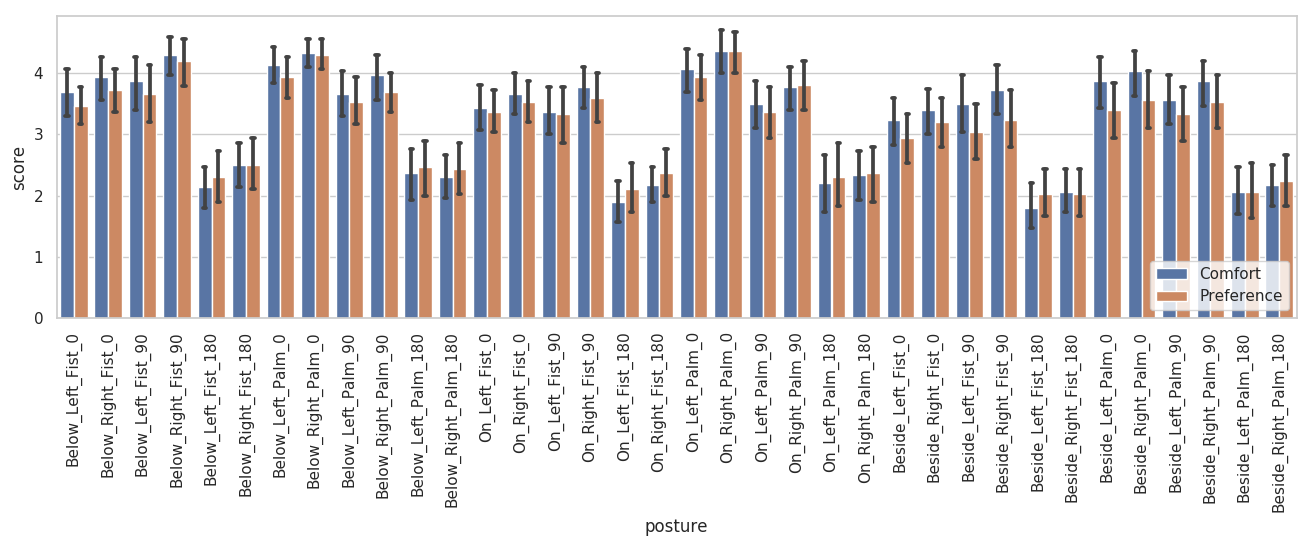

In [0]:
sns.set(style="whitegrid")
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.barplot(x="posture", y="score", hue="rating", data=df_postures_stats, capsize=0.1)
ax.legend(loc='lower right')

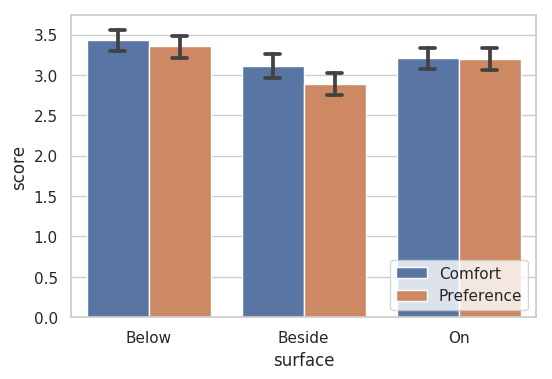

In [0]:
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
ax = sns.barplot(x="surface", y="score", hue="rating", data=df_postures_stats_melted, capsize=0.1)
ax.legend(loc='lower right')

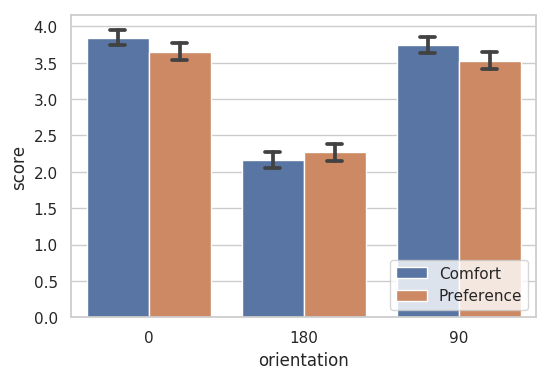

In [0]:
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
ax = sns.barplot(x="orientation", y="score", hue="rating", data=df_postures_stats_melted, capsize=0.1)
ax.legend(loc='lower right')

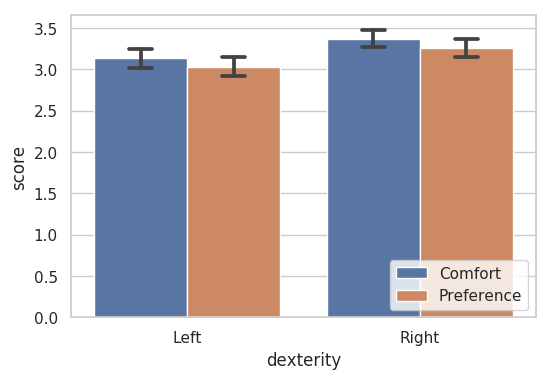

In [0]:
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
ax = sns.barplot(x="dexterity", y="score", hue="rating", data=df_postures_stats_melted, capsize=0.1)
ax.legend(loc='lower right')

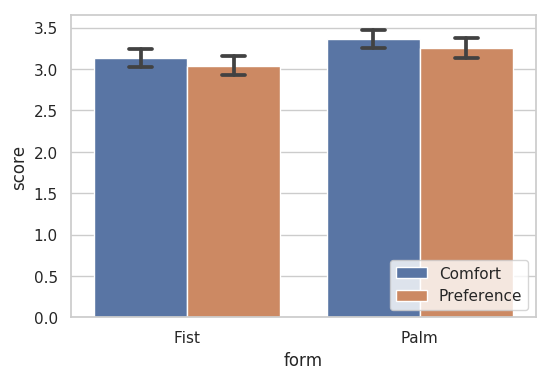

In [0]:
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
ax = sns.barplot(x="form", y="score", hue="rating", data=df_postures_stats_melted, capsize=0.1)
ax.legend(loc='lower right')

**To do**

- ~Compare postures across different dimensions (SURFACE, WRIST_ORIENTATION, HAND_FORM & DEXTERITY)~
- Give design recomendations based on above^^